In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_data.csv')
sub = pd.read_csv('./data/sample_submission.csv')

train_origin = pd.read_csv('./data/train_data.csv')
test_origin = pd.read_csv('./data/test_data.csv')
sub_origin = pd.read_csv('./data/sample_submission.csv')

# 1. Feature Instruction
- userID 사용자의 고유번호입니다. 총 7,442명의 고유 사용자가 있으며, train/test셋은 이 userID를 기준으로 90/10의 비율로 나누어졌습니다.

- assessmentItemID 문항의 고유번호입니다. 총 9,454개의 고유 문항이 있습니다. 이 일련 번호에 대한 규칙은 DKT 2강 EDA에서 다루었으니 강의 들어보시면 좋을 것 같습니다.

- testId 시험지의 고유번호입니다. 문항과 시험지의 관계는 아래 그림을 참고하여 이해하시면 됩니다. 총 1,537개의 고유한 시험지가 있습니다.

- answerCode 사용자가 해당 문항을 맞췄는지 여부에 대한 이진 데이터이며 0은 사용자가 해당 문항을 틀린 것, 1은 사용자가 해당 문항을 맞춘 것입니다.

- Timestamp 사용자가 해당문항을 풀기 시작한 시점의 데이터입니다.

- KnowledgeTag 문항 당 하나씩 배정되는 태그로, 일종의 중분류 역할을 합니다. 태그 자체의 정보는 비식별화 되어있지만, 문항을 군집화하는데 사용할 수 있습니다. 912개의 고유 태그가 존재합니다.
    - Test data에 대해서도 마찬가지이며, 이 때 Timestamp상 가장 마지막에 푼 문항의 answerCode는 모두 -1로 표시되어 있습니다. **_여러분들의 과제는 이 -1로 처리되어 있는 interaction의 정답 여부를 맞추는 것입니다._**

# 2. 기본 전처리
- testId
    - 모두 공통이므로 제거:
        - 맨 앞 A, 가운데 000, 첫번째 세번재 0
    - test_num:
        - 마지막 세개 (test ID)
    - test_cat:
        - 테스트 대분류
- assessmentItemID
    - questionID
        - 모두 공통이므로 제거:
            - 맨 앞 A
        - test_num 및 test_cat으로 있기 때문에 제거
            - test_ID
- elapsed time 만들기

### testId

In [3]:
# train testID column 쪼개기
train['test_num'] = train['testId'].apply(lambda x : x[-3:])
train['test_cat'] = train['testId'].apply(lambda x : x[2])
# train = train.drop(['testId'], axis=1)


### assessmentItemID

In [4]:
# train assessmentID 쪼개기
train['questionID'] = train['assessmentItemID'].apply(lambda x : x[-3:])
train['question_answer'] = train['questionID'].apply(str) + '_' + train['answerCode'].apply(str)

In [5]:
user2question = train.groupby(by=['userID', 'test_num'])['question_answer'].apply(list).to_dict() # user의 시험지 별 푼 문제와 정답 딕셔너리

### Timestamp -> elapsed time

In [6]:
# elapsed time: 문제 푸는데 소요 된 시간
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train['elapsed_time'] = train['Timestamp'].astype(int)

tmp = list(train['elapsed_time'].diff() // 10**9)
tmp.append(99999)
train['elapsed_time'] = tmp[1:]

In [7]:
# user 또는 시험지가 바뀔 때 값이 잘못 들어가서 그 경우를 -1로 바꿔줌
# -> 이 경우에는 user가 같은 시험지를 풀었을 때 값을 고려 못 해줌
train['Timestamp'] = train['Timestamp'].astype(str)
tmp_dict = train.groupby(['userID', 'testId'])['Timestamp'].max().to_frame().reset_index()
tmp_dict['rev_time'] = -1
tmp_dict = tmp_dict.set_index(['userID', 'testId', 'Timestamp']).to_dict()
tmp_dict = tmp_dict['rev_time']
train['tmp'] = tuple(zip(train.userID, train.testId, train.Timestamp))
train['tmp'] = train['tmp'].map(tmp_dict)
train['tmp'] = train['tmp'].fillna(train['elapsed_time'])
train['elapsed_time'] = train['tmp']
train.drop(['tmp'], axis=1, inplace=True)

In [8]:
train['elapsed_time'].value_counts().sort_index() # 총 369284개가 -1

-1.0           369284
 0.0             3278
 1.0            53821
 2.0           109998
 3.0            75778
                ...  
 7567850.0          1
 7682832.0          1
 8898824.0          1
 12292722.0         1
 14763424.0         1
Name: elapsed_time, Length: 14118, dtype: int64

- 한 유저가 동일한 시험지를 두 번 이상 풀었을 경우를 고려 못 해줌 => 고려 필요
- 한 유저가 동일한 시험지를 연속해서 풀었을 수도 있음 => 확인 필요 => 288번 있음

In [9]:
train.sort_values('elapsed_time', ascending=False).head(20)
train[(train['userID'] == 4492 )& (train['testId']=='A060000152')]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,test_cat,questionID,question_answer,elapsed_time
2058390,4492,A060152001,A060000152,1,2020-04-08 11:37:36,1458,152,6,001,001_1,32.0
2058391,4492,A060152002,A060000152,0,2020-04-08 11:38:08,1458,152,6,002,002_0,4.0
2058392,4492,A060152003,A060000152,0,2020-04-08 11:38:12,1458,152,6,003,003_0,4.0
2058393,4492,A060152004,A060000152,0,2020-04-08 11:38:16,1458,152,6,004,004_0,3.0
2058394,4492,A060152005,A060000152,0,2020-04-08 11:38:19,1458,152,6,005,005_0,3.0
2058395,4492,A060152006,A060000152,0,2020-04-08 11:38:22,1458,152,6,006,006_0,4.0
2058396,4492,A060152007,A060000152,0,2020-04-08 11:38:26,1458,152,6,007,007_0,14763424.0
2058418,4492,A060152001,A060000152,1,2020-10-07 10:29:54,1458,152,6,001,001_1,541.0
2058419,4492,A060152002,A060000152,1,2020-10-07 10:38:55,1458,152,6,002,002_1,126.0
2058420,4492,A060152003,A060000152,1,2020-10-07 10:41:01,1458,152,6,003,003_1,9.0


- 연속해서 동일한 시험지를 푼 경우가 있는지 확인 => 있음 (아래 for문 -> 288명)

In [11]:
# 그 전에 모든 시험지에 1번이 있는지 확인 필요 -> 1번이 한번 나왔는데 또 나오면 그 타임스템프와 그 앞 타임스템프를 저장할 계획
train.groupby(['testId'])['questionID'].value_counts().head(20) # 흠 일단은 다 있는듯 한데 확인은 따로 해봐야 할 것 같음
train.groupby(['testId'])['questionID'].nunique().value_counts() # 문제 2개만 있는 애들 존재

# 문제는 1번 부터 시작하는가?
exam = train.groupby(['testId'])['questionID'].unique().reset_index()
exam[exam['questionID'].apply(len)==2] #001, 002
train.groupby(['testId'])['questionID'].sum().apply(lambda x : x[:3]).value_counts() # ㄴㄴ
train.groupby(['testId'])['questionID'].sum().apply(lambda x : x[:6]).value_counts() # 그럼 최소한 오름차순인가? ㄴㄴ 8->7, 6->5, 7->5 등 다양함

exam['len'] = exam['questionID'].apply(len)
exam[exam['len']==4] # 걍 처음만 아닌게 아니라 끝에 1이 들어간 경우도 있고 아주 엉망 진창임

,testId,questionID,len
14,A010000015,"[001, 003, 004, 005]",4
19,A010000020,"[001, 002, 004, 003]",4
22,A010000023,"[001, 002, 003, 004]",4
31,A010000032,"[002, 003, 004, 001]",4
32,A010000033,"[001, 002, 003, 004]",4
...,...,...,...
1043,A060000069,"[001, 002, 003, 004]",4
1058,A060000084,"[001, 002, 003, 004]",4
1067,A060000093,"[001, 002, 003, 004]",4
1150,A060000176,"[002, 003, 004, 007]",4


In [12]:
test2len = { key:value for key, value in zip(exam['testId'], exam['len'])}
train['question_len'] = train['testId'].map(test2len) # test별 question 개수 칼럼 붙여줌

# 연속해서 동일한 시험지를 푼 경우 확인 => (len(same_test)==289)
tmp = 1
same_test = []
for i in tqdm(range(1,len(train))):
    cur_test = train['testId'][i]
    prev_test = train['testId'][i-1]
    if cur_test == prev_test:
        tmp += 1
        if tmp > train['question_len'][i]:
            same_test.extend([i-1])
            tmp = 1
    else:
        tmp = 1

# 위 코드를 for문 안 쓰고 해보려고 했으나.. 이렇게 하면 걍 모든 두번 이상 푼 애들이 다 모여버림 인덱스도 못 따옴 => 엥?? 이게 원래 하려던거 아닌가?
checking_double_test = train.groupby(['userID', 'testId', 'question_len'])['assessmentItemID'].count().reset_index().set_index(['userID', 'testId'])
checking_double_test['result'] = checking_double_test['question_len'] < checking_double_test['assessmentItemID']
checking_double_test = checking_double_test[checking_double_test['result']==True].reset_index()
checking_double_test


100%|██████████| 2266585/2266585 [00:40<00:00, 56148.71it/s]


,userID,testId,question_len,assessmentItemID,result
0,1,A040000155,6,12,True
1,1,A040000156,6,12,True
2,1,A040000157,6,12,True
3,1,A040000158,6,12,True
4,1,A040000160,5,10,True
...,...,...,...,...,...
7316,6698,A050000187,7,14,True
7317,6858,A010000095,5,10,True
7318,6858,A010000191,5,10,True
7319,6977,A040000167,5,10,True


In [13]:
# 전부 2배 혹은 3배임 => 두 번 이상 푼 애들은 시험지에 제공되는 모든 문제  다  풂
checking_double_test['double'] = (checking_double_test['question_len'] * 2 == checking_double_test['assessmentItemID']) | (checking_double_test['question_len'] * 3 == checking_double_test['assessmentItemID'])
checking_double_test[checking_double_test['double'] == False]

,userID,testId,question_len,assessmentItemID,result,double


In [14]:
train['tmp'] = tuple(zip(train['userID'], train['testId'])) # userID랑 testId 쌍의 column 생성
user2test= checking_double_test.groupby(by=['userID', 'testId'])['question_len'].sum().to_dict() # (userID, testId):question_len 형태의 dictionary
train['tmp_q'] = train['tmp'].map(user2test)


In [15]:
# question_cnt = list(checking_double_test['question_len'].cumsum()-1)
# # question_cnt = train.groupby('tmp')['tmp_q'].mean().apply(lambda x : str(x).replace('nan', '0')).astype(float).astype(int).cumsum().unique().tolist()
# question_cnt = question_cnt[1:]
# question_cnt = [ value-1 for value in question_cnt]
#  checking_double_test의 testId순서랑 train의 TestId 순서가 달라서 이렇게 하면 안 됨

question_cnt_tmp = train[train['tmp_q'].notnull()].reset_index()
question_cnt_tmp

,index,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,test_cat,questionID,question_answer,elapsed_time,question_len,tmp,tmp_q
0,1166,1,A040155001,A040000155,1,2020-06-21 22:57:14,2111,155,4,001,001_1,41.0,6,"(1, A040000155)",6.0
1,1167,1,A040155002,A040000155,1,2020-06-21 22:57:55,2111,155,4,002,002_1,38.0,6,"(1, A040000155)",6.0
2,1168,1,A040155003,A040000155,0,2020-06-21 22:58:33,2111,155,4,003,003_0,16.0,6,"(1, A040000155)",6.0
3,1169,1,A040155004,A040000155,1,2020-06-21 22:58:49,2111,155,4,004,004_1,81.0,6,"(1, A040000155)",6.0
4,1170,1,A040155005,A040000155,0,2020-06-21 23:00:10,2111,155,4,005,005_0,94.0,6,"(1, A040000155)",6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91067,2264852,7329,A040198004,A040000198,1,2020-01-02 12:51:04,2133,198,4,004,004_1,227150.0,4,"(7329, A040000198)",4.0
91068,2264863,7329,A040198001,A040000198,1,2020-10-12 12:08:49,2133,198,4,001,001_1,4.0,4,"(7329, A040000198)",4.0
91069,2264864,7329,A040198002,A040000198,1,2020-10-12 12:08:53,2133,198,4,002,002_1,9.0,4,"(7329, A040000198)",4.0
91070,2264865,7329,A040198003,A040000198,1,2020-10-12 12:09:02,2133,198,4,003,003_1,6.0,4,"(7329, A040000198)",4.0


In [19]:
question_cnt_tmp = train[train['tmp_q'].notnull()].reset_index()
question_cnt = [6]
while sum(question_cnt) < list(checking_double_test['question_len'].cumsum())[-1]:
    question_cnt.append(question_cnt_tmp['tmp_q'][sum(question_cnt)])
question_cnt = (pd.Series(question_cnt).cumsum()-1).astype(int)

train[train['tmp_q'].isna()==False][['elapsed_time']].reset_index().iloc[question_cnt] # 뭐지 왜 중간 부터 인덱싱이 안 맞지

,index,elapsed_time
5,1171,166645.0
11,1177,27703.0
17,1202,119527.0
23,1224,135548.0
28,1239,115055.0
...,...,...
45092,775650,4.0
45100,775707,35.0
45108,775719,4.0
45116,775727,5.0


- 왠지는 모르겠는데 인덱싱이 안 맞아서 해결이 안 됨
- 전처리 친구들에게 맡긴다...~

In [314]:
train.loc[same_test, 'elapsed_time'] = -1 # 이거는 한 테스트를 연속으로 푼 애들 -1로 바꾸는거

# 3. EDA

### 한 테스트를 보는데 얼마의 시간이 소요되는지 확인 (median)

In [22]:
# 평균적으로 한 테스트를 보는데 얼마의 시간이 소요되는지 확인
train['Timestamp'] = pd.to_datetime(train['Timestamp'])
train.groupby(by=['userID', 'testId'])['Timestamp'].apply(lambda x : max(x) - min(x))

tmp = train.groupby(by=['userID', 'testId'])['Timestamp'].apply(lambda x : max(x) - min(x)).to_frame().groupby('testId').median()
tmp['Timestamp'].max() #15분 이상 걸린 애들 다 -1로 밀어도 될듯 (한 시험 전체를 푸는데 max 14분인데 한 문제를 푸는데 15분 이상이 걸렸다는건 이상치임)

Timedelta('0 days 00:14:36')

- 한 테스트를 보는데 15분 정도 소요됨 => 한 문제에 15분 이상 걸린 애들은 -1로 밀어도 되지 않을까? 하는 생각
- 근데 밀려고 했으나 진짜로 15분 정도 썼다면? 한 문제에? -> threshold를 지정해서 밀던가 아니면 한 테스트가 아니라 문제 하나를 푸는데 소요한 mediandmf qhkqhwk

### 한 문제당 15분 이상 소요한 애들의 정답 비율

In [16]:
# 한 문제 15분 이상 걸린 애들의 정답 비율
train[train['elapsed_time'] > 900]['answerCode'].value_counts()

1    19240
0     8351
Name: answerCode, dtype: int64

### 한 문제를 푸는데 얼마의 시간이 소요되는지 (median) -> 27 초

In [27]:
# 문제별 소요 시간 median
tmp = train.groupby(['userID', 'assessmentItemID'])['elapsed_time'].max().to_frame().groupby('assessmentItemID').median().reset_index()
tmp = tmp['elapsed_time']
tmp = [ value for value in tmp if value != -1.0]
np.median(tmp)


27.0

- 문제 푼 시간이 오래 걸린 애들은 전처리가 필요하겠다
- 어떻게 할 것인가?
    1. 동일한 문제를 푼 다른 애들의 평균 값과 해당 유저의 평균 소요 시간을 반영한 가중평균
    2. 특정한 값 (ex. 200)으로 Threshold주고 그 값으로 밀자

In [18]:
# # 문제 푼 시간이 오래 걸리면 99999로 바꿈 -> 동일한 문제를 푼 다른 애들의 평균 값과 해당 유저의 평균 값을 반영한 값 or 200으로 threshold
# time_outlier = 200
# train.loc[train[train['elapsed_time']>time_outlier].index, 'elapsed_time'] = 99999
# # VER1. 200으로 threshold
# train.loc[train[train['elapsed_time']>99999].index, 'elapsed_time'] = time_outlier
# # VER2. 알아서 하세요.. 문제 평균값이랑 유저 평균 값 고려해서 하는건...

### 한 유저가 같은 시험지를 두 번 이상 푼 적 있나?

In [31]:
train.groupby(['userID', 'assessmentItemID'])['testId'].count().value_counts() # 같은 시험지를 3번 까지 푼 애들도 있음

1    2175514
2      44285
3        834
Name: testId, dtype: int64

### knowledgetag는 시험지 별로 균일하게 분포하는가? -> 아니요

In [33]:
# tag는 시험지 별로 균일하게 분포 하는가? => 아닌 것 같음 한 시험지가 한 태그로 다 밀려 있는 경우도 있음
train.groupby("testId")["KnowledgeTag"].value_counts().to_frame()

KnowledgeTag
testId     KnowledgeTag              
A010000001 5844                  1585
A010000002 5844                   930
           6803                   620
A010000003 6804                   646
           6806                   646
...                               ...
A090000073 10196                   90
           4243                    45
A090000074 4243                   135
           2648                    90
           10196                   45

[2677 rows x 1 columns]

### knowledgetag의 개수는 시험지의 카테고리 별로 균일하게 분포하는가? -> 아니요

<AxesSubplot: >

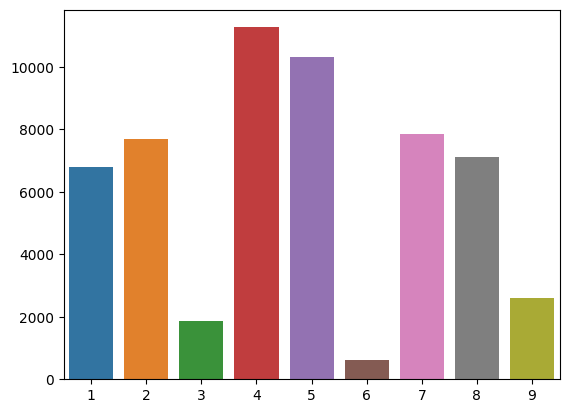

In [86]:
tmp = train.groupby("test_cat")["KnowledgeTag"].value_counts().rename('KnolwedgeTagCnt').reset_index()
tmp = dict(zip(tmp.test_cat, tmp.KnowledgeTag))

sns.barplot(x = list(tmp.keys()), y = list(tmp.values()))

### 그렇다면 카테고리별 시험지 자체의 개수는? -> 9번 카테고리 빼고 꽤나 균일하게 분포함

<AxesSubplot: xlabel='test_cat'>

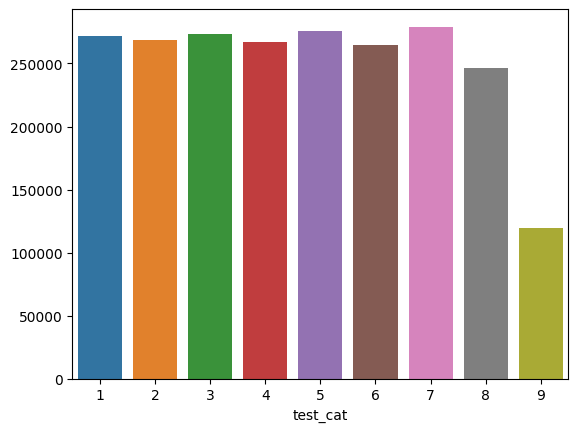

In [90]:
tmp = train.groupby('test_cat')['KnowledgeTag'].count()
sns.barplot(x = tmp.index, y = tmp.values)

### 개수 대비 knowledge tag의 분포 => 이건 이렇게 계산하면 안 될 거 같은데.... 나 바보라 모르겠어ㅜㅜ

In [95]:
tmp = train.groupby("test_cat")["KnowledgeTag"].value_counts().rename('KnolwedgeTagCnt').reset_index()
tmp = dict(zip(tmp.test_cat, tmp.KnowledgeTag))
cnt = train.groupby('test_cat')['KnowledgeTag'].count()
tmp = { key:cnt/value for (key, value), cnt in zip(tmp.items(), cnt)} ; tmp

{'1': 39.982659808963994,
 '2': 34.87483753574214,
 '3': 146.0064,
 '4': 23.719875776397515,
 '5': 26.69115369725126,
 '6': 429.9739837398374,
 '7': 35.53513238289206,
 '8': 34.573473684210526,
 '9': 45.68886337543054}

### knowledgetag는 고유한 category를 갖는가?

In [105]:
tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7, tmp8, tmp9 = train.groupby("test_cat")["KnowledgeTag"].unique().apply(set)
tmp = [tmp1, tmp2, tmp3, tmp4, tmp5, tmp6, tmp7, tmp8, tmp9]

In [109]:
for i, a in enumerate(tmp):
    for j, b in enumerate(tmp):
        if a == b:
            continue
        if a.intersection(b) != set():
            print(i+1, j+1)
            print(a.intersection(b))

7 8
{7863}
8 7
{7863}


- 7863번 knowledgetag 제외 모두 고유한 category를 가짐

### test cat의 분포 및 cat에 따른 정답율?

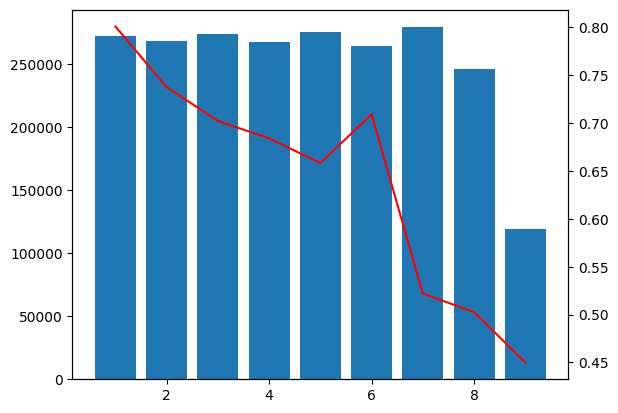

In [96]:
# test의 cat의 분포 및 정답률 그래프
fig,ax1 = plt.subplots()
ax1.bar(range(1,10), train.value_counts('test_cat').sort_index())
ax2 = ax1.twinx()
ax2.plot(range(1,10), train.groupby('test_cat')['answerCode'].mean(), c = 'red')
plt.show()